In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from keras.models import Sequential
import os
from sklearn.ensemble import RandomForestRegressor
import cv2
import keras as K

In [2]:
output_train = pd.read_csv("../input/y-train/y_train.csv")

In [3]:
archive = np.load('../input/lung-cancer/train_images/images/patient_003.npz')
scan = archive['scan']
mask = archive['mask']
scan.shape

(92, 92, 92)

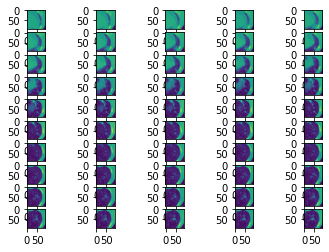

In [4]:
fig = plt.figure()
for i in range(50):
    sliced_scan = scan[:,:,i]
    sliced_scan = np.squeeze(sliced_scan)
    y = fig.add_subplot(10,5,i+1)
    y.imshow(sliced_scan)
plt.show()

In [5]:
print(np.expand_dims(scan,-1).shape)
print(scan.sum(axis=1).shape)

(92, 92, 92, 1)
(92, 92)


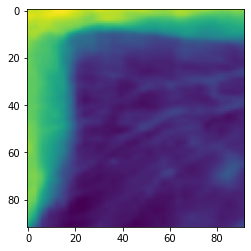

<Figure size 360x360 with 0 Axes>

In [6]:
plt.imshow(scan.sum(axis=1))
plt.figure(figsize=(5,5))
plt.show()

#### loading images and storing them in arrays

In [7]:
mypath = '../input/lung-cancer/train_images/images/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(onlyfiles)

300

In [8]:
images_arrays = []

for i in range(len(onlyfiles)):
    archive = np.load(f'../input/lung-cancer/train_images/images/{onlyfiles[i]}')
    scan = archive['scan']
    scan = scan.flatten()
    #mask = archive['mask']
    images_arrays.append(scan)

In [9]:
np.array(images_arrays).shape

(300, 778688)

## linear regression on all 800k components

In [10]:
output_train
y_train = output_train.SurvivalTime

In [11]:
y_train

0      1378
1       379
2       573
3       959
4      2119
       ... 
295    1540
296     946
297     559
298    1952
299     858
Name: SurvivalTime, Length: 300, dtype: int64

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(images_arrays, y_train, test_size=0.3, random_state=3)

In [13]:

reg = LinearRegression().fit(X_train, y_train)
print(f"Training set R2 score : {reg.score(X_train, y_train)}")
print(f"Training set R2 score : {reg.score(X_valid, y_valid)}")

Training set R2 score : 1.0
Training set R2 score : -0.16329949711933378


In [14]:

y_pred = reg.predict(X_valid)
r2_score(y_pred, y_valid)

-1.3070400039824706

In [15]:
ytrain_pred = reg.predict(X_train)

print(f'RMSE on Training set : {np.sqrt(np.mean((ytrain_pred - y_train)**2))}')
print(f'RMSE on Validation set : {np.sqrt(np.mean((y_pred - y_valid)**2))}')

RMSE on Training set : 4.422995221094663e-11
RMSE on Validation set : 718.9958073469338


In [16]:
data = {'actual':y_valid, 'predicted':y_pred}
pd.DataFrame(data=data, columns = ['actual','predicted'])

,actual,predicted
84,1280,1035.125739
217,2240,1511.469030
211,618,877.050495
286,1456,1748.326822
31,582,1092.808926
...,...,...
198,161,-54.256652
246,799,875.512977
292,2212,1483.007938
101,456,731.697852


## PCA

In [17]:
images_arrays = StandardScaler().fit_transform(images_arrays)
print("observations centrees reduites : ",images_arrays)

observations centrees reduites :  [[ 0.65617158  0.57701657  0.51880384 ...  0.8847135   0.84196005
   0.79337306]
 [ 0.7973816   0.79584489  0.79686491 ... -2.02033142 -2.01402551
  -2.00187838]
 [ 1.03508514  0.96761337  0.91704385 ...  0.39101177  0.37673163
   0.37266578]
 ...
 [ 1.01155013  1.00055526  0.98538089 ...  0.91589467  0.9014059
   0.81402127]
 [ 0.51731506  0.48054387  0.45517969 ... -2.16324508 -2.18202466
  -2.18255022]
 [-1.45727172 -1.46538114 -0.60286626 ... -0.24040676 -0.72689355
  -0.8636458 ]]


In [18]:
images_arrays.shape

(300, 778688)

In [19]:
pca = PCA()
pca.fit_transform(images_arrays) 

array([[ 1.61365301e+02,  1.10516090e+01,  3.09947594e+01, ...,
         1.03338683e+01,  6.52255858e+00,  7.52402120e-13],
       [-1.85524409e+02, -4.17743500e+02, -1.89431339e+01, ...,
        -3.64280839e+00,  8.23761084e-01,  7.52402120e-13],
       [-1.60099252e+02,  1.56993600e+02, -2.84475816e+02, ...,
        -2.83039972e+00,  3.66432516e-01,  7.52402120e-13],
       ...,
       [-1.28008608e+02,  6.63303853e+02, -1.72419484e+02, ...,
        -4.28423223e-01,  5.95684208e+00,  7.52402120e-13],
       [-7.39048687e+01, -5.21968384e+02,  4.06372183e+01, ...,
        -3.35876824e+01,  4.52717722e+00,  7.52402120e-13],
       [-6.17191949e+02,  3.76271715e+02, -6.04219837e+01, ...,
        -1.26822767e+00, -2.73319026e+00,  7.52402120e-13]])

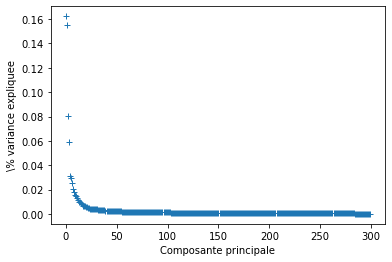

In [20]:
plt.plot(pca.explained_variance_ratio_,'+')
plt.xlabel('Composante principale')
plt.ylabel('\% variance expliquee')
plt.show()

In [21]:
print(len(pca.explained_variance_ratio_))

300


In [22]:
sum(pca.explained_variance_ratio_[:20])

0.691591127176345

In [23]:
pca.components_.shape

(300, 778688)

In [24]:
pca_X = pca.components_[:,:20]

In [25]:
pca_X.shape

(300, 20)

In [26]:
y_train = output_train.SurvivalTime

X_train, X_valid, y_train, y_valid = train_test_split(pca_X, y_train, test_size=0.3, random_state=3)

In [27]:
reg = LinearRegression().fit(X_train, y_train)

print(f"Training set R2 score : {reg.score(X_train, y_train)}")
print(f"Training set R2 score : {reg.score(X_valid, y_valid)}")

Training set R2 score : 0.09095296484315496
Training set R2 score : -0.15080645047489583


In [28]:
y_pred = reg.predict(X_valid)
r2_score(y_pred, y_valid)

-6.713668202647549

In [29]:
ytrain_pred = reg.predict(X_train)

print(f'RMSE on Training set : {np.sqrt(np.mean((ytrain_pred - y_train)**2))}')
print(f'RMSE on Validation set : {np.sqrt(np.mean((y_pred - y_valid)**2))}')

RMSE on Training set : 709.4637333583164
RMSE on Validation set : 715.1246224536987


In [30]:
data = {'actual':y_valid, 'predicted':y_pred}
pd.DataFrame(data=data, columns = ['actual','predicted'])

,actual,predicted
84,1280,902.826129
217,2240,541.005209
211,618,923.218930
286,1456,781.463662
31,582,688.594542
...,...,...
198,161,1698.934934
246,799,579.687471
292,2212,814.191065
101,456,908.911076


## Random forest after PCA

In [31]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0,max_depth = 2)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_valid)

In [32]:
y_pred = regressor.predict(X_valid)

In [33]:
ytrain_pred = regressor.predict(X_train)

print(f'RMSE on Training set : {np.sqrt(np.mean((ytrain_pred - y_train)**2))}')
print(f'RMSE on Validation set : {np.sqrt(np.mean((y_pred - y_valid)**2))}')

RMSE on Training set : 676.6972531200132
RMSE on Validation set : 686.199907692603


In [34]:
print(f" standard dev of y_valid : {np.std(y_valid)}")

 standard dev of y_valid : 666.6234512845084


In [35]:
data = {'actual':y_valid, 'predicted':y_pred}
pd.DataFrame(data=data, columns = ['actual','predicted'])

,actual,predicted
84,1280,1068.847422
217,2240,880.817739
211,618,1017.524695
286,1456,867.526369
31,582,596.300686
...,...,...
198,161,1248.557420
246,799,668.769391
292,2212,872.528128
101,456,940.924246


## Keras CNN

In [36]:
images = []

for i in range(len(onlyfiles)):
    archive = np.load(f'../input/lung-cancer/train_images/images/{onlyfiles[i]}')
    scan = archive['scan']
    images.append(scan)
    
    
y_train = output_train.SurvivalTime

X_train, X_valid, y_train, y_valid = train_test_split(images, y_train, test_size=0.3, random_state=3)
X_train = np.array(X_train)/np.max(X_train)
X_valid = np.array(X_valid)/np.max(X_valid)

## TRYING OUT MANY CNN STRUCTURES - TATONNEMENT

### conv2ds + maxpools + dense

In [37]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(92, 92, 92)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 32)        26528     
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 90, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [38]:
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size = 4) 

Epoch 1/10
53/53 [==============================] - 1s 28ms/step - loss: 1338379.8750 - root_mean_squared_error: 1156.8837 - val_loss: 1119018.7500 - val_root_mean_squared_error: 1057.8368
Epoch 2/10
53/53 [==============================] - 1s 13ms/step - loss: 1336889.7500 - root_mean_squared_error: 1156.2395 - val_loss: 1121641.7500 - val_root_mean_squared_error: 1059.0759
Epoch 3/10
53/53 [==============================] - 1s 13ms/step - loss: 1335406.8750 - root_mean_squared_error: 1155.5980 - val_loss: 1121299.5000 - val_root_mean_squared_error: 1058.9143
Epoch 4/10
53/53 [==============================] - 1s 14ms/step - loss: 1333704.1250 - root_mean_squared_error: 1154.8611 - val_loss: 1117257.2500 - val_root_mean_squared_error: 1057.0039
Epoch 5/10
53/53 [==============================] - 1s 14ms/step - loss: 1331871.3750 - root_mean_squared_error: 1154.0673 - val_loss: 1119990.5000 - val_root_mean_squared_error: 1058.2960
Epoch 6/10
53/53 [==============================] - 1s 

In [39]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(92, 92, 92)))
#model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
#model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((4, 4))) 
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((4, 4))) 
#model.add(layers.BatchNormalization())

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(32, activation='relu'))
#model.add(layers.BatchNormalization())

model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 90, 90, 32)        26528     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 18, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)      

In [40]:
model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=20, shuffle = True, validation_data=(X_valid, y_valid), batch_size = 4) 

Epoch 1/20
53/53 [==============================] - 1s 23ms/step - loss: 1335862.8750 - root_mean_squared_error: 1155.7953 - val_loss: 1116468.5000 - val_root_mean_squared_error: 1056.6307
Epoch 2/20
53/53 [==============================] - 1s 13ms/step - loss: 1322954.8750 - root_mean_squared_error: 1150.1978 - val_loss: 1095099.8750 - val_root_mean_squared_error: 1046.4702
Epoch 3/20
53/53 [==============================] - 1s 13ms/step - loss: 1296888.8750 - root_mean_squared_error: 1138.8103 - val_loss: 960078.9375 - val_root_mean_squared_error: 979.8362
Epoch 4/20
53/53 [==============================] - 1s 14ms/step - loss: 1244595.7500 - root_mean_squared_error: 1115.6145 - val_loss: 964350.5625 - val_root_mean_squared_error: 982.0135
Epoch 5/20
53/53 [==============================] - 1s 18ms/step - loss: 1156812.0000 - root_mean_squared_error: 1075.5520 - val_loss: 666036.2500 - val_root_mean_squared_error: 816.1104
Epoch 6/20
53/53 [==============================] - 1s 14ms/s

### CONV3D + batch normalization + dropout

In [41]:
#os.mkdir('/kaggle/working/augmented/')

#print(X_train.shape)
X_train = np.expand_dims(X_train, axis = -1)
X_valid = np.expand_dims(X_valid, axis = -1)
print(X_train.shape)
print(X_valid.shape)

(210, 92, 92, 92, 1)
(90, 92, 92, 92, 1)


In [42]:
def creatConv3d_model():
    model = Sequential()
    
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(92,92,92,1),data_format = 'channels_last'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dropout(0.2))
    
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    #model.add(layers.Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(1))

    
    
    return model

In [43]:
model = creatConv3d_model()


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 90, 90, 90, 32)    896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 45, 45, 45, 32)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 45, 45, 45, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 43, 43, 43, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 21, 21, 21, 64)    0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 21, 21, 21, 64)    256       
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 21, 64)   

In [44]:
checkpoint_filepath = '/kaggle/working/augmented/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)


model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=20, callbacks=[model_checkpoint_callback],
                    validation_data=(X_valid, y_valid), batch_size = 4)

Epoch 1/20
53/53 [==============================] - 7s 130ms/step - loss: 881110.6875 - root_mean_squared_error: 938.6750 - val_loss: 654262.5000 - val_root_mean_squared_error: 808.8649
Epoch 2/20
53/53 [==============================] - 5s 103ms/step - loss: 671513.6875 - root_mean_squared_error: 819.4594 - val_loss: 452075.4375 - val_root_mean_squared_error: 672.3655
Epoch 3/20
53/53 [==============================] - 5s 102ms/step - loss: 631072.5625 - root_mean_squared_error: 794.4008 - val_loss: 450106.8125 - val_root_mean_squared_error: 670.9000
Epoch 4/20
53/53 [==============================] - 5s 103ms/step - loss: 608725.3125 - root_mean_squared_error: 780.2085 - val_loss: 457523.1250 - val_root_mean_squared_error: 676.4045
Epoch 5/20
53/53 [==============================] - 6s 104ms/step - loss: 585472.1250 - root_mean_squared_error: 765.1615 - val_loss: 497334.2188 - val_root_mean_squared_error: 705.2193
Epoch 6/20
53/53 [==============================] - 5s 103ms/step - lo

In [45]:
#model.load_weights(checkpoint_filepath)


### using Resnet50 model

(92,92,92) to (92,92,3)

In [46]:
images_Z3d = []

for i in range(len(onlyfiles)):
    archive = np.load(f'../input/lung-cancer/train_images/images/{onlyfiles[i]}')
    scan = archive['scan']

    dim1 = np.sum(scan[:,:,:30], axis = -1, keepdims = True)
    dim2 = np.sum(scan[:,:,30:62], axis = -1, keepdims = True)
    dim3 = np.sum(scan[:,:,62:], axis = -1, keepdims = True)
    concat = np.concatenate((dim1, dim2), axis = -1)
    img = np.concatenate((concat, dim3), axis = -1)
    
    images_Z3d.append(img)

#print(dim1.shape)
images_Z3d = np.array(images_Z3d)
images_Z3d.shape


y_train = output_train.SurvivalTime

X_train, X_valid, y_train, y_valid = train_test_split(images_Z3d, y_train, test_size=0.3, random_state=3)
X_train = np.array(X_train)/np.max(X_train)
X_valid = np.array(X_valid)/np.max(X_valid)

In [47]:
input_t = K.Input(shape=(92,92,3))
res_model = K.applications.ResNet50(include_top = False,
                                   weights = "imagenet",
                                   input_tensor = input_t)

for layer in res_model.layers:
    layer.trainable = False
    
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)

94773248/94765736 [==============================] - 1s 0us/step
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn

In [48]:
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 92, 92, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 98, 98, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 46, 46, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 46, 46, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [49]:
model = Sequential()
model.add(res_model)
model.add(Flatten())
model.add(layers.BatchNormalization())
model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 18432)             73728     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [50]:
checkpoint_filepath = '/kaggle/working/augmented/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)


model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=50, callbacks=[model_checkpoint_callback],
                    validation_data=(X_valid, y_valid), batch_size = 4)

Epoch 1/50
53/53 [==============================] - 2s 46ms/step - loss: 1337546.8750 - root_mean_squared_error: 1156.5236 - val_loss: 1118864.7500 - val_root_mean_squared_error: 1057.7640
Epoch 2/50
53/53 [==============================] - 1s 15ms/step - loss: 1334730.8750 - root_mean_squared_error: 1155.3055 - val_loss: 1115427.3750 - val_root_mean_squared_error: 1056.1379
Epoch 3/50
53/53 [==============================] - 1s 15ms/step - loss: 1329680.7500 - root_mean_squared_error: 1153.1178 - val_loss: 1105464.5000 - val_root_mean_squared_error: 1051.4108
Epoch 4/50
53/53 [==============================] - 1s 15ms/step - loss: 1319315.0000 - root_mean_squared_error: 1148.6144 - val_loss: 1081212.5000 - val_root_mean_squared_error: 1039.8137
Epoch 5/50
53/53 [==============================] - 1s 15ms/step - loss: 1290354.5000 - root_mean_squared_error: 1135.9377 - val_loss: 1015427.1250 - val_root_mean_squared_error: 1007.6840
Epoch 6/50
53/53 [==============================] - 1s 

In [51]:
model = Sequential()
model.add(res_model)
model.add(Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 18432)             73728     
_________________________________________________________________
dropout_4 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 18433     
Total params: 23,679,873
Trainable params: 55,297
Non-trainable params: 23,624,576
_________________________________________________________________


In [52]:
checkpoint_filepath = '/kaggle/working/augmented/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)


model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=20, callbacks=[model_checkpoint_callback],
                    validation_data=(X_valid, y_valid), batch_size = 4)

Epoch 1/20
53/53 [==============================] - 2s 46ms/step - loss: 1309056.8750 - root_mean_squared_error: 1144.1403 - val_loss: 1033233.6875 - val_root_mean_squared_error: 1016.4810
Epoch 2/20
53/53 [==============================] - 1s 16ms/step - loss: 1132013.8750 - root_mean_squared_error: 1063.9614 - val_loss: 787910.1250 - val_root_mean_squared_error: 887.6430
Epoch 3/20
53/53 [==============================] - 1s 14ms/step - loss: 835941.5625 - root_mean_squared_error: 914.2984 - val_loss: 548578.9375 - val_root_mean_squared_error: 740.6611
Epoch 4/20
53/53 [==============================] - 1s 13ms/step - loss: 631920.9375 - root_mean_squared_error: 794.9346 - val_loss: 455042.2812 - val_root_mean_squared_error: 674.5682
Epoch 5/20
53/53 [==============================] - 1s 14ms/step - loss: 567481.3125 - root_mean_squared_error: 753.3135 - val_loss: 444445.7188 - val_root_mean_squared_error: 666.6676
Epoch 6/20
53/53 [==============================] - 1s 13ms/step - lo

#### Training the resnet50 layers

In [53]:
input_t = K.Input(shape=(92,92,3))
res_model = K.applications.ResNet50(include_top = False,
                                   weights = "imagenet",
                                   input_tensor = input_t)

for layer in res_model.layers[154:]:
    layer.trainable = True
    
res_model.summary() #23,534,592   25,583,592

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 92, 92, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 98, 98, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 46, 46, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 46, 46, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [54]:
model = Sequential()

model.add(res_model)

model.add(Flatten())

model.add(layers.BatchNormalization())

model.add(Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

model.add(Dense(64, activation = 'relu'))

model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 18432)             73728     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 128)              

In [55]:
checkpoint_filepath = '/kaggle/working/augmented/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)


model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=20, callbacks=[model_checkpoint_callback],
                    validation_data=(X_valid, y_valid), batch_size = 4)

Epoch 1/20
53/53 [==============================] - 4s 81ms/step - loss: 1338617.8750 - root_mean_squared_error: 1156.9866 - val_loss: 1090926.3750 - val_root_mean_squared_error: 1044.4742
Epoch 2/20
53/53 [==============================] - 2s 38ms/step - loss: 1335789.1250 - root_mean_squared_error: 1155.7634 - val_loss: 1055295.2500 - val_root_mean_squared_error: 1027.2756
Epoch 3/20
53/53 [==============================] - 3s 55ms/step - loss: 1331685.5000 - root_mean_squared_error: 1153.9868 - val_loss: 32866562.0000 - val_root_mean_squared_error: 5732.9365
Epoch 4/20
53/53 [==============================] - 2s 33ms/step - loss: 1322303.5000 - root_mean_squared_error: 1149.9146 - val_loss: 1095551.3750 - val_root_mean_squared_error: 1046.6859
Epoch 5/20
53/53 [==============================] - 4s 80ms/step - loss: 1297155.6250 - root_mean_squared_error: 1138.9274 - val_loss: 752367360.0000 - val_root_mean_squared_error: 27429.3164
Epoch 6/20
53/53 [==============================] -

In [56]:
def createCnn():
    input_t = K.Input(shape=(92,92,3))
    res_model = K.applications.ResNet50(include_top = False,
                                   weights = "imagenet",
                                   input_tensor = input_t)

    for layer in res_model.layers:
        layer.trainable = False
        
    model = Sequential()
    
    model.add(res_model)
    
    model.add(Flatten())
    
    model.add(layers.BatchNormalization())
    
    model.add(Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(Dense(128, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(Dense(64, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(Dense(64, activation = 'relu'))

    model.add(Dense(1))

    return model

### predict on validation set

In [57]:
y_pred = model.predict(X_valid).flatten()
y_pred.shape

(90,)

In [58]:
data = {'actual':y_valid, 'predicted':y_pred}
pd.DataFrame(data=data, columns = ['actual','predicted'])

,actual,predicted
84,1280,1032.051514
217,2240,1032.050659
211,618,1032.052246
286,1456,1032.062134
31,582,1032.052490
...,...,...
198,161,923.046326
246,799,1032.094482
292,2212,10662.159180
101,456,1032.113281


### submissions resnet

In [59]:
#loaded_model = model.load_weights(checkpoint_filepath)

In [60]:
mypath = '../input/lung-cancer/test_images/images/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(len(onlyfiles))

test_images_Z3d = []

for i in range(len(onlyfiles)):
    archive = np.load(f'../input/lung-cancer/test_images/images/{onlyfiles[i]}')
    scan = archive['scan']

    dim1 = np.sum(scan[:,:,:30], axis = -1, keepdims = True)
    dim2 = np.sum(scan[:,:,30:62], axis = -1, keepdims = True)
    dim3 = np.sum(scan[:,:,62:], axis = -1, keepdims = True)
    concat = np.concatenate((dim1, dim2), axis = -1)
    img = np.concatenate((concat, dim3), axis = -1)
    
    test_images_Z3d.append(img)

#print(dim1.shape)
test_images_Z3d = np.array(test_images_Z3d)
test_images_Z3d.shape

125


(125, 92, 92, 3)

In [61]:
test_images_Z3d

array([[[[ -9603,  -1624,  -2777],
         [ -7532,  -6435,  -5598],
         [ -6065, -11899,  -7087],
         ...,
         [ -2765, -13908, -26047],
         [-19836, -24123, -25914],
         [-29287, -26559, -22934]],

        [[ -2231,   1972,   2935],
         [  -526,   1510,   1277],
         [  1322,    265,   -185],
         ...,
         [ -4536, -13572, -26093],
         [-21787, -24675, -25080],
         [-29492, -26599, -22900]],

        [[  3026,   2633,   3439],
         [  4326,   1978,   1675],
         [  5115,   2063,   1073],
         ...,
         [ -5333, -13612, -26014],
         [-22390, -24742, -24526],
         [-29485, -26070, -23359]],

        ...,

        [[-26074, -27493, -25877],
         [-26306, -26652, -26326],
         [-26198, -26557, -25960],
         ...,
         [-24523, -27443, -28220],
         [-26237, -29081, -28773],
         [-27399, -27707, -28026]],

        [[-26261, -27791, -26151],
         [-26039, -27038, -26123],
         [-2

In [62]:
test_images_Z3d = np.array(test_images_Z3d)/np.max(test_images_Z3d)

yhat_test = model.predict(test_images_Z3d).flatten()

test_clinic = pd.read_csv("../input/test-csvs/clinical_data.csv")
result = {'PatientID':test_clinic.PatientID, 'SurvivalTime':yhat_test}
submission = pd.DataFrame(data=result, columns = ['PatientID','SurvivalTime'])
submission['Event'] = 'nan'
#submission.to_csv('second.csv', index = False)

In [63]:
submission

,PatientID,SurvivalTime,Event
0,13,9511.842773,nan
1,155,1032.058838,nan
2,404,1032.038574,nan
3,407,1032.070190,nan
4,9,7009.619141,nan
...,...,...,...
120,66,1032.053345,nan
121,132,1032.057373,nan
122,169,1032.074707,nan
123,199,1032.051636,nan
